In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/.shortcut-targets-by-id/1yBbLm6bTCmPgJT5wEo5RfTNj--2wTVHa/Kaggle


In [5]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip \*.zip && rm *.zip.

Archive:  fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                
rm: cannot remove '*.zip.': No such file or directory


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')
true.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [8]:
true['label'] = 1
fake['label'] = 0

In [9]:
# Combine the sub-datasets in one.
frames = [true.loc[:5000][:], fake.loc[:5000][:]]
df = pd.concat(frames)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
X = df.drop('label', axis=1) 
y = df['label']
# Delete missing data
df = df.dropna()
df2 = df.copy()
df2.reset_index(inplace=True)

# Ethan test


# Random Forest

In [11]:
import nltk

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
import re
import string
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.PorterStemmer()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df2['body_len'] = df2['text'].apply(lambda x: len(x) - x.count(" "))
df2['punct%'] = df2['text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [stemmer.stem(word) for word in tokens if word not in stopwords]
    return text

In [13]:
from sklearn.model_selection import train_test_split

X=df2[['text', 'body_len', 'punct%']]
y=df2['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=4998, ngram_range=(1,3))
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])

X_train = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

framesX = [X_train.loc[:4998][:], X_test.loc[:4998][:]]
X_vect = pd.concat(framesX)
X_train.head()

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:532: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


,body_len,punct%,0,1,2,3,4,5,6,7,...,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997
0,913,2.2,0.044181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3211,2.4,0.014718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1623,4.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1724,2.7,0.026211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1865,2.3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Precision: 0.999 / Recall: 1.0 / F1-Score: 1.0 / Accuracy: 1.0
Accuracy: 99.950%
Confusion matrix, without normalization
42.6271915435791
MSE: 0.0004997501249375312
R2: 0.9980008552063685


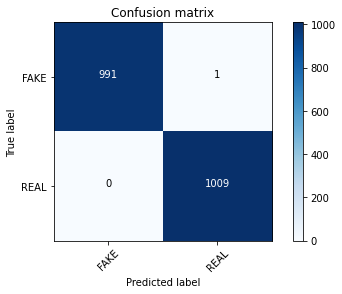

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
import time

start = time.time()

rf = RandomForestClassifier(n_estimators=500, max_depth=None)

rf_model = rf.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

precision, recall, fscore, train_support = score(y_test, y_pred_rf, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred_rf), 3)))
print("Accuracy: %.3f%%" % (acs(y_test,y_pred_rf) * 100.0))
end = time.time()

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, classes=['FAKE', 'REAL'])

print(end - start)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("MSE: " + str(mse_rf))

r2score_rf = r2_score(y_test, y_pred_rf)
print("R2: " + str(r2score_rf))

# XGBoost

In [32]:
! pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [17]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100
xgb_model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)
preds = xgb_model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")


TypeError: ignored

# XGBoost 2

Accuracy: 99.85%
Confusion matrix, without normalization
MSE: 0.0014992503748125937
R2: 0.9940025656191055


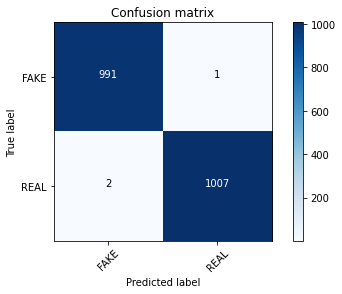

In [50]:
xgb_model = XGBClassifier(learning_rate=0.001,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=42, gamma=0.01, reg_lambda = 0.1)
xgb_model.fit(X_train, y_train)
# make predictions for test data
y_pred_xgb = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred_xgb]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cm_xgb, classes=['FAKE', 'REAL'])

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("MSE: " + str(mse_xgb))

r2score_xgb = r2_score(y_test, y_pred_xgb)
print("R2: " + str(r2score_xgb))

# K-NN

Accuracy: 0.6996501749125438
Confusion matrix, without normalization
MSE: 0.3003498250874563
R2: -0.20148602097253754


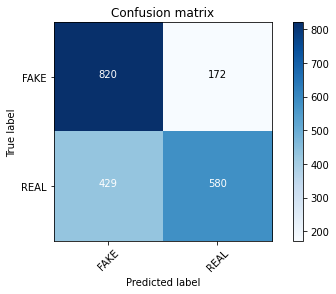

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=67)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
cm_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm_knn, classes=['FAKE', 'REAL'])

mse_knn = mean_squared_error(y_test, y_pred_knn)
print("MSE: " + str(mse_knn))

r2score_knn = r2_score(y_test, y_pred_knn)
print("R2: " + str(r2score_knn))

# K-NN 2

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
k_values = [i for i in range (1,100)]
scores = []

scaler = StandardScaler()
X_vect = scaler.fit_transform(X_vect)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_vect, y_train)
    y_pred_knn = knn.predict(X_test_vect)
    accuracy = accuracy_score(y_test, y_pred_knn)
    scores.append(accuracy)

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
best_index = np.argmax(scores)

best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_vect, y_train)
y_pred_knn = knn.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred_knn)

print("Accuracy:", accuracy)

NameError: ignored

# End of Ethan Test

In [12]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(df2)):
    review = re.sub('[^a-zA-Z]', ' ', df2['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


KeyboardInterrupt: ignored

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=5002, ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()
y = df2['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-a358c2e5af01>", line 2, in <module>
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py", line 2417, in train_test_split
    arrays = indexable(*arrays)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py", line 378, in indexable
    check_consistent_length(*result)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py", line 332, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [9849, 10002]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-pac

ValueError: ignored

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import numpy as np
import itertools
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-91f6bf0abc52>", line 6, in <module>
    classifier.fit(X_train, y_train)
NameError: name 'X_train' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/

NameError: ignored

In [ ]:
from sklearn.model_selection import cross_val_score
def validate(model):
  scores = cross_val_score(classifier, X, y)
  return scores
validate(classifier)


In [69]:
# Tokenization
review = re.sub('[^a-zA-Z]', ' ', fake['text'][13070])
review = review.lower()
review = review.split() 
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
# Vectorization
val = tfidf_v.transform([review]).toarray()
# Predict 
classifier.predict(val)



AttributeError: ignored

In [55]:
import pickle


pickle.dump(rf, open('rfmodel.pkl', 'wb'))
pickle.dump(xgb_model, open('xgbmodel.pkl', 'wb'))

In [ ]:
# Load model and vectorizer
joblib_model = pickle.load(open('model2.pkl', 'rb'))
joblib_vect = pickle.load(open('tfidfvect2.pkl', 'rb'))
val_pkl = joblib_vect.transform([review]).toarray()
joblib_model.predict(val_pkl)